In [38]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib.pyplot as plt

In [ ]:
import cv2
import numpy as np
import onnxruntime as rt
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class AI:
    def __init__(self, model_path: str):
        self.sess = rt.InferenceSession(model_path, providers=[
            'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name

        # Define same preprocessing used in training
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy to PIL
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert to tensor and rescale to [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        """
        Preprocess BGR image to match model input.
        Converts BGR to RGB, applies resizing, normalization, etc.
        Returns a numpy array of shape (1, 3, 224, 224) with dtype float32.
        """
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)  # Apply transforms
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        return img_tensor.numpy().astype(np.float32)

    def postprocess(self, detections: np.ndarray) -> np.ndarray:
        """
        Postprocess model outputs.
        Converts to 1D numpy array if needed.
        """
        return detections.squeeze()  # Should be shape (2,)

    def predict(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)

        assert inputs.dtype == np.float32
        assert inputs.shape == (1, 3, 224, 224)

        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        outputs = self.postprocess(detections)

        assert outputs.dtype == np.float32
        assert outputs.shape == (2,)
        assert outputs.max() < 1.0
        assert outputs.min() > -1.0

        return outputs


def check(img_name):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        image_path = f'camera/{img_name}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image '{img_name}' not found in camera/ directory!")

    model_path = 'model_jetbot.onnx'
    ai = AI(model_path)
    prediction = ai.predict(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()



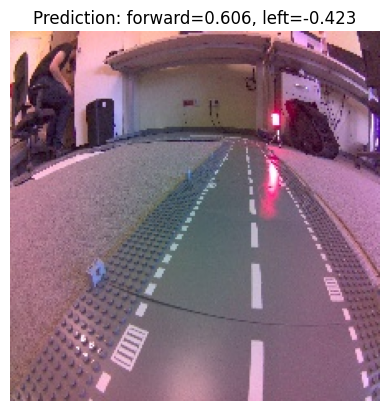

Prediction: forward=0.6059, left=-0.423


In [40]:
check("0016")

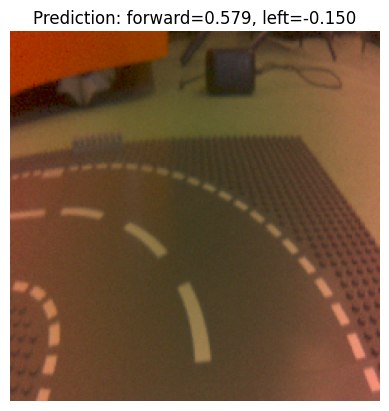

Prediction: forward=0.5789, left=-0.150


In [41]:
check(2)

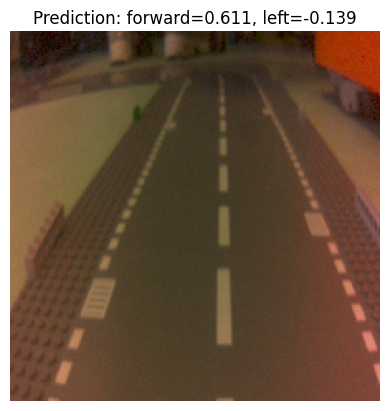

Prediction: forward=0.6109, left=-0.139


In [42]:
check(3)

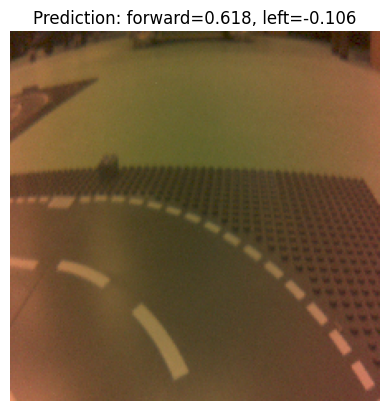

Prediction: forward=0.6182, left=-0.106


In [43]:
check(4)

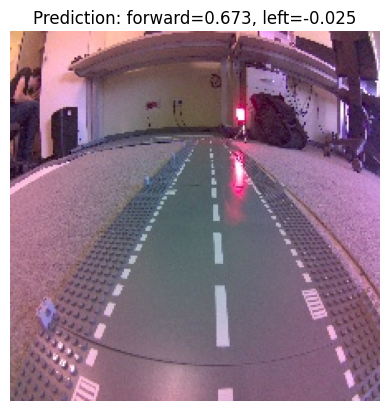

Prediction: forward=0.6730, left=-0.025


In [44]:
check("0029")

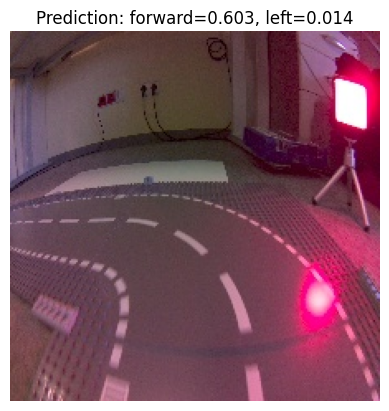

Prediction: forward=0.6030, left=0.014


In [45]:
check("0086")

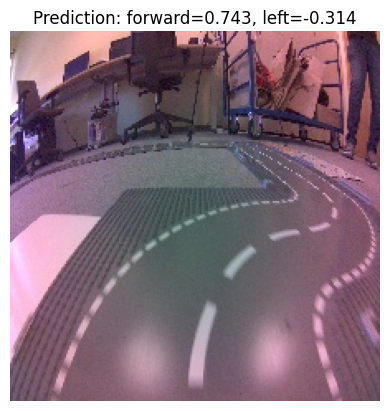

Prediction: forward=0.7427, left=-0.314


In [46]:
check("0704")

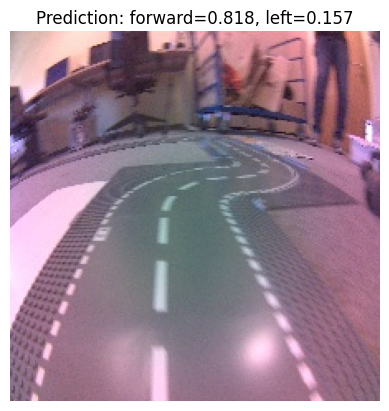

Prediction: forward=0.8176, left=0.157


In [47]:
check("0696")

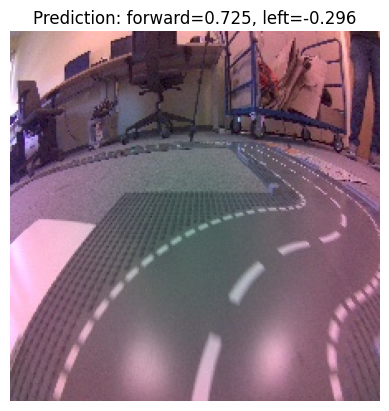

Prediction: forward=0.7251, left=-0.296


In [48]:
check("0705")

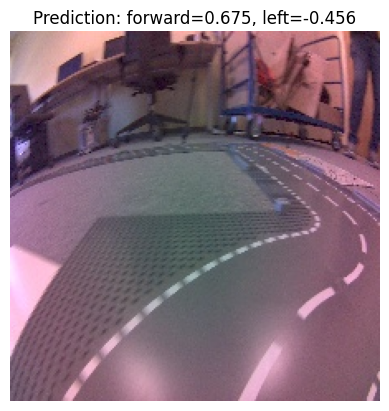

Prediction: forward=0.6753, left=-0.456


In [49]:
check("0708")